This notebook uses different layers of Llama3 as inputs to the MTEB (multitask embedding benchmark), which is an evaluation framework with a ton of datasets. The goal is to see if the layer-wise MTEB performance is correlated with entropy.

Authors: Oscar Skean

In [1]:
%load_ext autoreload
%autoreload 2

from transformers import AutoTokenizer, AutoModelForCausalLM, GPT2LMHeadModel, GPT2Model, AutoModel
import torch
import torch.nn.functional as F
import numpy as np
from utils import get_model_path, get_dataloader, normalize, EleutherAI_sizes
import matplotlib.pyplot as plt
import tqdm
import repitl.matrix_itl as itl
from datasets import load_dataset, load_from_disk
from transformers.utils import logging
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
!wandb login # needed for llama access

wandb: Currently logged in as: ofskean727 (cliplab). Use `wandb login --relogin` to force relogin


In [3]:
model_types = ["baseline-llama", "llm2vec-unsupervised"]
num_layers = 33
task_names = ["ArXivHierarchicalClusteringP2P", "Banking77Classification",  "EmotionClassification", "TwitterSemEval2015", "ClimateFEVER"]


In [ ]:
import mteb
from models.mteb_model_wrapper import baseline_llama3, llm2vec_llama3_8b_supervised, llm2vec_llama3_8b_unsupervised

for model_type in model_types:
    for layer in reversed(range(num_layers)):
        if model_type == "baseline-llama":
            model = baseline_llama3.loader(layer_cutoff=layer)
        elif model_type == "llm2vec-unsupervised":
            model = llm2vec_llama3_8b_unsupervised.loader(layer_cutoff=layer)
        
        # needed to properly neatly save to folder
        model.mteb_model_meta = mteb.ModelMeta(
                        name=model_type,
                        revision=f"layer-{layer}",
                        release_date=None,
                        languages=None,
                    )

        #tasks = mteb.get_tasks(tasks=["Clustering"])
        tasks = mteb.get_tasks(tasks=task_names)

        evaluation = mteb.MTEB(tasks=tasks)
        results = evaluation.run(model)
        del model

In [ ]:
# import mteb
# from models.mteb_model_wrapper import baseline_llama3, llm2vec_llama3_8b_supervised
# from utils import get_dataloader


# model_name = "baseline-llama"

# model = baseline_llama3.loader(layer_cutoff=2)
# dataloader = get_dataloader(model.model.tokenizer, "wikitext", split="train")

# with torch.no_grad():
#     for batch in tqdm.tqdm(dataloader):
#         batch = {k: v.to(model.model.model.device) for k, v in batch.items()}
#         outputs_2 = model.model.model(**batch)
        
#         break


# Calculate layer entropies

In [12]:
import mteb
from models.mteb_model_wrapper import baseline_llama3, llm2vec_llama3_8b_supervised
from utils import get_model_path, get_dataloader, normalize, EleutherAI_sizes
from models.llm2vec import batch_to_device
import torch
import numpy as np
import repitl.matrix_itl as itl

def no_pooling_forward(model, sentence_feature):
    if "embed_mask" in sentence_feature:
        sentence_feature.pop("embed_mask")
    outputs = model.model(**sentence_feature)

    return outputs.hidden_states

def calculate_sentence_entropy(sentence_embeddings):
    N, D = sentence_embeddings.shape


    sentence_embeddings = normalize(sentence_embeddings)
    if N > D:
        cov = sentence_embeddings.T @ sentence_embeddings
    else:
        cov = (sentence_embeddings @ sentence_embeddings.T)
    cov /= torch.trace(cov)
    entropy = itl.matrixAlphaEntropy(cov, alpha=1)
    logN_normalized_entropy = entropy / np.log(N)

    return logN_normalized_entropy.item()

def calculate_batch_entropy(features, embeddings):
    seq_lengths = features["attention_mask"].sum(dim=-1)

    total_entropy = 0
    for i, length in enumerate(seq_lengths):
        sentence_entropy = calculate_sentence_entropy(embeddings[i, -length:, :].double())
        total_entropy += sentence_entropy
    
    return total_entropy

def encode_batch_and_get_layerwise_entropy(model, sentences_batch, layer_cutoff=-1, device=None):
    model.to(device)
    features = model.tokenize(
        [model.prepare_for_tokenization(sentence) for sentence in sentences_batch]
    )
    features = batch_to_device(features, device)
    with torch.no_grad():
        embeddings = no_pooling_forward(model, features)

        layerwise_entropies = []
        for layer in range(len(embeddings)):
            layerwise_entropies.append(calculate_batch_entropy(features, embeddings[layer].detach()))
    return layerwise_entropies

def encode_dataset_and_get_entropy(model, sentences, batch_size=8, device=None):
    if isinstance(sentences[0], str) and isinstance(sentences[-1], int):
        sentences = [sentences]
    # required for MEDI version of MTEB
    if isinstance(sentences[0], str):
        sentences = [[""] + [sentence] for sentence in sentences]

    concatenated_input_texts = []
    for sentence in sentences:
        assert isinstance(sentence[0], str)
        assert isinstance(sentence[1], str)
        concatenated_input_texts.append(
            model._convert_to_str(sentence[0], sentence[1])
        )
    sentences = concatenated_input_texts

    model.eval()
    length_sorted_idx = np.argsort([-model._text_length(sen) for sen in sentences])
    sentences_sorted = [sentences[idx] for idx in length_sorted_idx]

    batched_layerwise_entropies = []
    for i in tqdm.tqdm(range(0, len(sentences_sorted), batch_size)):
        sentences_batch = sentences_sorted[i : i + batch_size]

        layerwise_entropies = encode_batch_and_get_layerwise_entropy(model, sentences_batch, device=device)
        layerwise_entropies = [x / len(sentences_batch) for x in layerwise_entropies]
        batched_layerwise_entropies.append(layerwise_entropies)

    batched_layerwise_entropies = np.array(batched_layerwise_entropies)
    batched_layerwise_entropies = np.mean(batched_layerwise_entropies, axis=0)
    return batched_layerwise_entropies

In [13]:
import mteb
import glob
import json


import mteb
from models.mteb_model_wrapper import baseline_llama3, llm2vec_llama3_8b_supervised, llm2vec_llama3_8b_unsupervised


tasks = mteb.get_tasks(tasks=task_names)
REDO_RESULTS = True
NUM_SAMPLES=64

for model_type in model_types:
    if model_type == "baseline-llama":
        model = baseline_llama3.loader()
    elif model_type == "llm2vec-unsupervised":
        model = llm2vec_llama3_8b_unsupervised.loader()

    model.model.eval()

    for task in tasks:
        # check if we've already calculated the entropy for this task
        if not REDO_RESULTS:
            with open(f"results/{model_type}/layer-0/{task.metadata.name}.json", "r") as f:
                results = json.load(f)
                if "avg_layerwise_entropy" in results:
                    print(f"Skipping {task.metadata.name} for {model_type} as it has already been calculated")
                    continue

        # load data from HF
        task.load_data(eval_splits=task.metadata.eval_splits)

        # load inputs
        task_dataset = task.dataset["test"]
        if "sentences" in task_dataset.features:
            sentences = task_dataset["sentences"]
        elif "text" in task_dataset.features:
            sentences = task_dataset["text"]
        else:
            print(task.dataset)
            print(task_dataset)
            raise ValueError("Dataset does not contain sentences or text, unsure where data is living")
        
        samples = sentences[0:NUM_SAMPLES]
        avg_layerwise_entropy = encode_dataset_and_get_entropy(model.model, samples)

        files = glob.glob(f"results/{model_type}/layer-*/{task.metadata.name}.json")
        for file in files:
            layer_num = int(file.split("/")[2].split("-")[1])

            # save entropy to json results file
            with open(file, "r") as f:
                results = json.load(f)
                results["avg_layerwise_entropy"] = avg_layerwise_entropy[layer_num]
                results["num_samples"] = len(samples)
                
            with open(file, "w") as f:
                json.dump(results, f)

    del model

/home/AD/ofsk222/miniconda3/envs/information_plane/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Map:   0%|          | 0/732723 [00:00<?, ? examples/s]

100%|██████████| 8/8 [00:02<00:00,  3.34it/s]
Repo card metadata block was not found. Setting CardData to empty.
100%|██████████| 8/8 [00:03<00:00,  2.45it/s]
/home/AD/ofsk222/miniconda3/envs/information_plane/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/home/AD/ofsk222/miniconda3/envs/information_plane/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


# Load Results

In [30]:
import json
import glob
import pandas as pd

results_per_layer = {
    model_type: {
        task_name : {} for task_name in task_names
    } for model_type in model_types
}
entropies_per_layer = {
    model_type: {
        task_name : {} for task_name in task_names
    } for model_type in model_types
}

for model_type in model_types:
    for task_name in task_names:
        files = glob.glob(f"results/{model_type}/layer-*/{task_name}.json")
        print(files)
        for file in files:
            layer_num = int(file.split("/")[2].split("-")[1])

            with open(file, "r") as f:
                file_json = json.load(f)
            score = float(file_json["scores"]["test"][0]["main_score"])
            results_per_layer[model_type][task_name][layer_num] = score
            entropies_per_layer[model_type][task_name][layer_num] = float(file_json["avg_layerwise_entropy"])

        results_per_layer[model_type][task_name] = pd.Series(results_per_layer[model_type][task_name])
        results_per_layer[model_type][task_name] = results_per_layer[model_type][task_name].sort_index()

        entropies_per_layer[model_type][task_name] = pd.Series(entropies_per_layer[model_type][task_name])
        entropies_per_layer[model_type][task_name] = entropies_per_layer[model_type][task_name].sort_index()

['results/baseline-llama/layer-6/ArXivHierarchicalClusteringP2P.json', 'results/baseline-llama/layer-11/ArXivHierarchicalClusteringP2P.json', 'results/baseline-llama/layer-18/ArXivHierarchicalClusteringP2P.json', 'results/baseline-llama/layer-0/ArXivHierarchicalClusteringP2P.json', 'results/baseline-llama/layer-24/ArXivHierarchicalClusteringP2P.json', 'results/baseline-llama/layer-20/ArXivHierarchicalClusteringP2P.json', 'results/baseline-llama/layer-26/ArXivHierarchicalClusteringP2P.json', 'results/baseline-llama/layer-31/ArXivHierarchicalClusteringP2P.json', 'results/baseline-llama/layer-10/ArXivHierarchicalClusteringP2P.json', 'results/baseline-llama/layer-19/ArXivHierarchicalClusteringP2P.json', 'results/baseline-llama/layer-29/ArXivHierarchicalClusteringP2P.json', 'results/baseline-llama/layer-22/ArXivHierarchicalClusteringP2P.json', 'results/baseline-llama/layer-30/ArXivHierarchicalClusteringP2P.json', 'results/baseline-llama/layer-15/ArXivHierarchicalClusteringP2P.json', 'result

In [31]:
print(results_per_layer)

{'baseline-llama': {'ArXivHierarchicalClusteringP2P': 0     0.485947
1     0.525626
2     0.560421
3     0.584623
4     0.579629
5     0.579758
6     0.554715
7     0.552052
8     0.542123
9     0.540334
10    0.540855
11    0.521361
12    0.523888
13    0.516184
14    0.522023
15    0.534105
16    0.549726
17    0.551346
18    0.568148
19    0.588132
20    0.576948
21    0.588550
22    0.585097
23    0.593816
24    0.604687
25    0.607477
26    0.601133
27    0.600450
28    0.599427
29    0.594504
30    0.610177
31    0.599136
32    0.593397
dtype: float64, 'Banking77Classification': 0     0.535455
1     0.594903
2     0.542662
3     0.521461
4     0.509123
5     0.546461
6     0.566104
7     0.585747
8     0.603864
9     0.593214
10    0.571851
11    0.527143
12    0.523149
13    0.564675
14    0.582532
15    0.608961
16    0.661429
17    0.661916
18    0.679740
19    0.685357
20    0.691818
21    0.708669
22    0.715714
23    0.728442
24    0.736948
25    0.740812
26    0.738052
27 

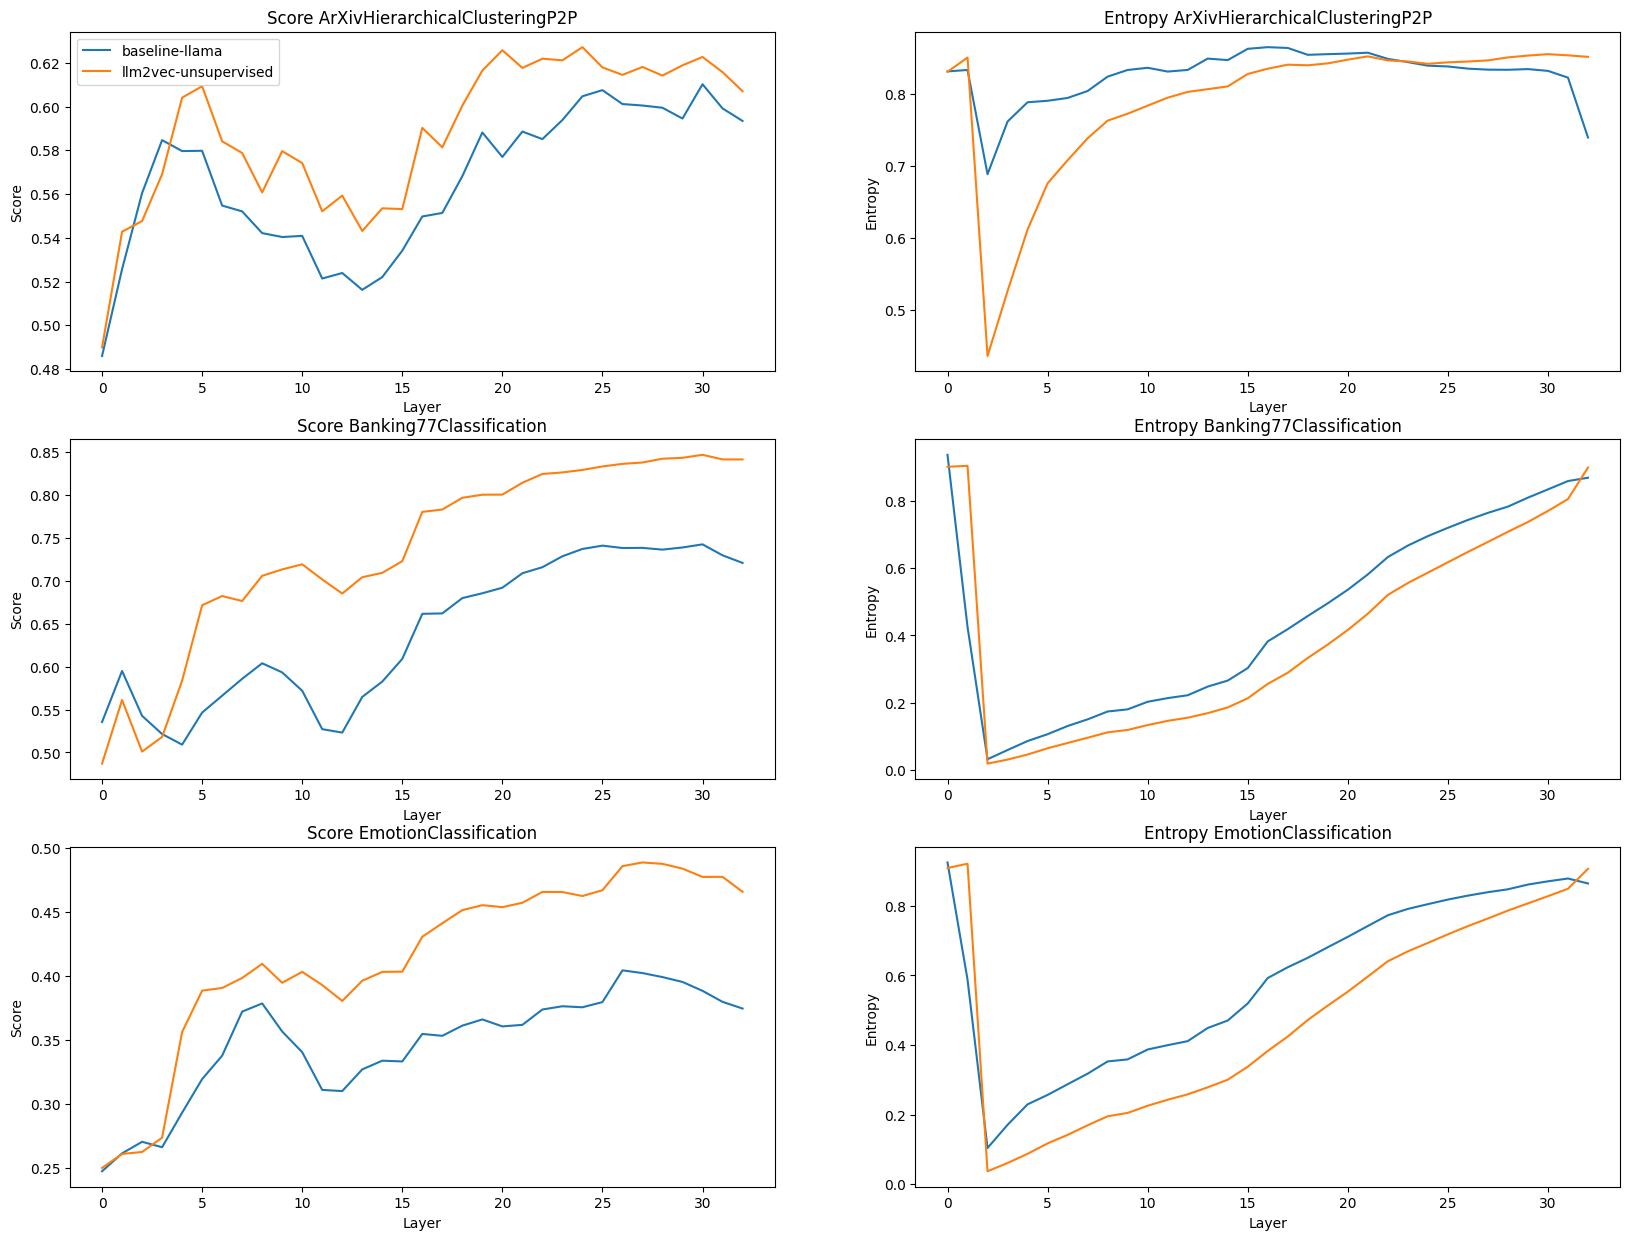

In [37]:
fig, axes = plt.subplots(len(task_names), 2, figsize=(20, 15))
for i, task_name in enumerate(task_names):
    for j, model_name in enumerate(model_types):
        axes[i, 0].plot(results_per_layer[model_name][task_name], label=model_name)
        axes[i, 0].set_title(f"Score {task_name}")
        axes[i, 0].set_xlabel("Layer")
        axes[i, 0].set_ylabel("Score")

        axes[i, 1].plot(entropies_per_layer[model_name][task_name], label=model_name)
        axes[i, 1].set_title(f"Entropy {task_name}")
        axes[i, 1].set_xlabel("Layer")
        axes[i, 1].set_ylabel("Entropy")

axes[0,0].legend()

total correlation 0.03643048128342246
first half correlation 0.8035714285714284


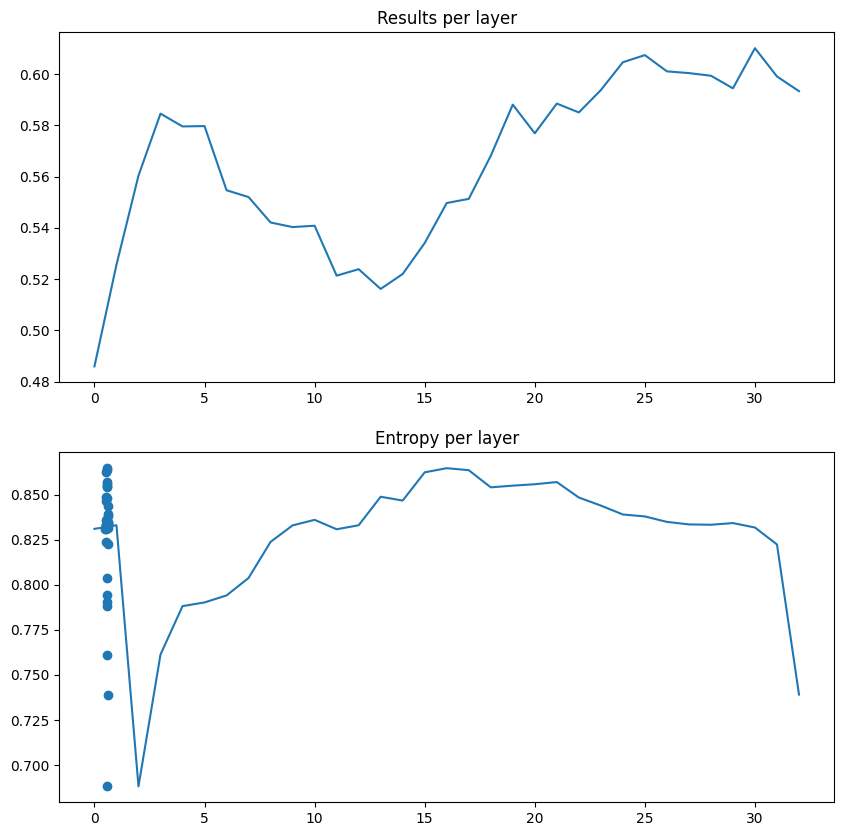

In [5]:
# plot results
import matplotlib.pyplot as plt

# compute correlation between results and entropy
correlation = results_per_layer.corr(-entropies_per_layer, method="spearman")
print("total correlation", correlation)

# early layers correlations
correlation = results_per_layer[:15].corr(-entropies_per_layer[:15], method="spearman")
print("first half correlation", correlation)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))
results_per_layer.plot(ax=axes[0], title="Results per layer")
entropies_per_layer.plot(ax=axes[1], title="Entropy per layer")

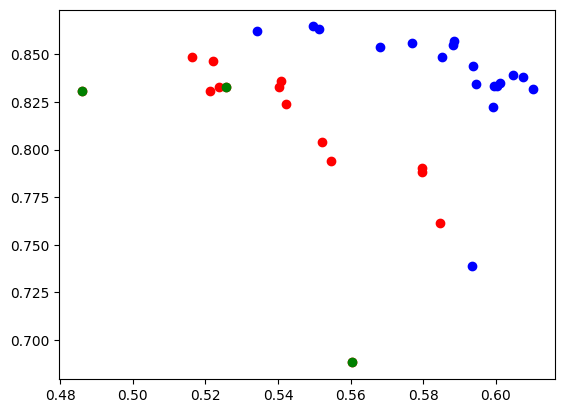

In [11]:
# #print(entropies_per_layer)

# plt.scatter(results_per_layer[0:15], entropies_per_layer[0:15], color="red")
# plt.scatter(results_per_layer[15:], entropies_per_layer[15:], color="blue")
# plt.scatter(results_per_layer[0:3], entropies_per_layer[0:3], color="green")

try more datasets
try more models (llama instruct)
try dataset that the model was trained on

on ood data, should be less compression
	can you interpolate between trained/untrained data and show how compression is controllable
	